In [1]:
# Install required packages
%pip install -q networkx matplotlib llama-index-core llama-index-llms-azure-openai llama-index-embeddings-azure-openai

Note: you may need to restart the kernel to use updated packages.


# Demo #10: Knowledge Graph RAG (GraphRAG) with Multi-Hop Reasoning

## Objective
Demonstrate how explicit entity-relationship graphs enable multi-hop reasoning and explainable answers impossible with pure vector search.

## Theoretical Background

### The Fundamental Limitation of Vector-Only RAG

While vector-based retrieval has become the standard for RAG, it has a **fundamental blind spot**:
- ✓ **Excels at capturing semantic similarity**: Can find documents about related topics
- ✗ **Fails to comprehend explicit, structured relationships**: Cannot represent the *nature* of relationships

**Example:**
- Vector search can determine that "Apple Inc." and "Tim Cook" are **related**
- But it cannot explicitly know that the **nature** of that relationship is "CEO of"
- It cannot answer: "Who is the CEO of Apple?" by traversing a CEO_OF relationship

This limitation has led to the emergence of **GraphRAG**, a paradigm that integrates **Knowledge Graphs (KGs)** into the retrieval process, merging:
- **Connectionist AI** (neural networks for semantic understanding)
- **Symbolic AI** (graphs for explicit reasoning and structure)

### What is a Knowledge Graph?

A **Knowledge Graph** represents information as a network of:
- **Nodes (Entities)**: People, places, companies, products, concepts
- **Edges (Relationships)**: The explicit connections between entities

This structure allows the system to move beyond simple document retrieval to perform **complex, multi-hop reasoning** across interconnected data points.

**Example Knowledge Graph:**
```
(Apple Inc.) --[CEO_OF]--> (Tim Cook)
(Apple Inc.) --[PRODUCES]--> (iPhone)
(iPhone) --[USES]--> (iOS)
(iOS) --[BASED_ON]--> (Unix)
```

### The LLM-Powered Virtuous Cycle

The primary historical barrier to using KGs was the **immense manual effort** required for their construction. However, a key modern development is using **LLMs themselves to automate** this process:

1. **Unstructured text** → fed to an LLM
2. LLM **extracts structured entities and relationships**
3. Structured data → used to **build a Knowledge Graph**
4. GraphRAG system **queries the KG** for structured context
5. LLM receives superior context → **generates accurate, well-reasoned answers**

This bootstrapping process has made GraphRAG a **practical and scalable** architecture for the first time.

### GraphRAG Architecture Components

A formal GraphRAG architecture consists of four main components:

1. **Query Processor**: Analyzes the user's natural language query and translates it into a formal graph query by identifying relevant entities and relationships
2. **Retriever**: Executes the query against the graph database using traversal algorithms (BFS, DFS) or Graph Neural Networks (GNNs)
3. **Organizer**: Prunes and refines the retrieved subgraph to remove irrelevant nodes/edges (noise)
4. **Generator**: Receives the structured graph data and synthesizes it into a final natural language response

### Key Capabilities

#### 1. Hybrid Retrieval
Combines vector search over unstructured text with structured graph traversal:
- Query → identify starting node (via vector search on node descriptions)
- System explores the **neighborhood** of that node
- Gathers rich, interconnected context

#### 2. Multi-Hop Reasoning
The **true power** of GraphRAG lies in answering complex questions that require **traversing multiple relationships**:

**Example:** "What products are manufactured by the subsidiary of Company X?"
- **Hop 1**: Find the subsidiary of Company X
- **Hop 2**: Find the products manufactured by that subsidiary

This synthesizes insights **not explicitly stated in any single document**.

**Conceptual Elevation:**
- **Standard RAG**: Excellent at answering "what" questions (retrieving factual snippets)
- **GraphRAG**: Elevates capability to answer "how" and "why" questions by tracing paths of causal or influential relationships

#### 3. Enhanced Explainability
Because relationships are **explicit** and the retrieval path is **discrete**, GraphRAG systems can:
- Present the **subgraph** or **traversal path** used to arrive at a conclusion
- Offer **transparent, auditable explanations**
- Far superior to simply citing a list of source documents

### Integration Patterns

Knowledge Graphs can be integrated into RAG systems in several ways:

1. **Direct Querying**: RAG system queries the KG in real-time for structured context
2. **Text-Graph Embedding**: Both text chunks and graph components are embedded into a shared vector space for unified semantic search
3. **Graph-Based Filtering**: KG acts as a filter to refine vector search results (only pass documents linked to specific entities)

## What We'll Demonstrate

In this demo, we'll build a **GraphRAG system** that:
1. **Automatically constructs** a Knowledge Graph from unstructured technical documents using an LLM
2. **Visualizes** the extracted entity-relationship network
3. Performs **multi-hop queries** that require traversing multiple relationships
4. Shows **explicit reasoning paths** (explainability)
5. **Compares** with standard vector-only RAG to highlight GraphRAG's unique capabilities

We'll demonstrate queries that are **impossible for standard RAG** but natural for GraphRAG.

---

**References:**
- *Knowledge Graph for RAG: Definition and Examples* - Lettria (Reference 44)
- *What is GraphRAG?* | IBM (Reference 46)
- *Enhancing the Accuracy of RAG Applications With Knowledge Graphs* - Neo4j (Reference 48)
- Curriculum: "The Semantic Frontier: Integrating Knowledge Graphs (GraphRAG)"

## 1. Environment Setup and Dependencies

In [2]:
import os
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# LlamaIndex core
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    Settings,
    KnowledgeGraphIndex,
    StorageContext
)

# Azure OpenAI
from llama_index.llms.azure_openai import AzureOpenAI
from llama_index.embeddings.azure_openai import AzureOpenAIEmbedding

# Graph store
from llama_index.core.graph_stores import SimpleGraphStore

print("✓ All imports successful")

✓ All imports successful


## 2. Azure OpenAI Configuration

In [3]:
# Azure OpenAI Configuration
llm = AzureOpenAI(
    model="gpt-4",
    deployment_name=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME", "gpt-4"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-15-preview",
    temperature=0.0  # Deterministic for entity extraction
)

embed_model = AzureOpenAIEmbedding(
    model="text-embedding-ada-002",
    deployment_name=os.getenv("AZURE_OPENAI_EMBEDDING_DEPLOYMENT_NAME", "text-embedding-ada-002"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-15-preview"
)

# Configure global settings
Settings.llm = llm
Settings.embed_model = embed_model
Settings.chunk_size = 512
Settings.chunk_overlap = 50

print("✓ Azure OpenAI configured")
print(f"  LLM: {llm.model}")
print(f"  Embedding: text-embedding-ada-002")

✓ Azure OpenAI configured
  LLM: gpt-4
  Embedding: text-embedding-ada-002


## 3. Load Documents for Knowledge Graph Construction

We'll use technical documents that contain clear entity relationships:
- Technologies and their components
- Models and their architectures
- Systems and their dependencies

In [4]:
# Load technical documentation
data_dir = Path("./data/tech_docs")

print(f"Loading documents from: {data_dir}")
documents = SimpleDirectoryReader(
    input_dir=str(data_dir),
    required_exts=[".md"]
).load_data()

print(f"\n✓ Loaded {len(documents)} documents:")
for doc in documents:
    filename = Path(doc.metadata['file_path']).name
    print(f"  - {filename}")

print(f"\nTotal characters: {sum(len(doc.text) for doc in documents):,}")

Loading documents from: data/tech_docs

✓ Loaded 6 documents:
  - bert_model.md
  - docker_containers.md
  - embeddings_ml.md
  - gpt4_model.md
  - rest_api.md
  - transformer_architecture.md

Total characters: 23,600


## 4. Construct Knowledge Graph with LLM

The `KnowledgeGraphIndex` will use the LLM to:
1. Extract entities (nodes) from the text
2. Identify relationships (edges) between entities
3. Build a structured graph representation

This is the **automated KG construction** that makes GraphRAG practical.

In [5]:
# Create a simple graph store (in-memory)
graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

print("Constructing Knowledge Graph...")
print("(This will take a few minutes as the LLM extracts entities and relationships)\n")

# Build the Knowledge Graph Index
# max_triplets_per_chunk controls how many (subject, predicate, object) triplets to extract per chunk
kg_index = KnowledgeGraphIndex.from_documents(
    documents,
    storage_context=storage_context,
    max_triplets_per_chunk=10,
    include_embeddings=True,  # Also create embeddings for hybrid retrieval
    show_progress=True
)

print("\n✓ Knowledge Graph constructed!")

Constructing Knowledge Graph...
(This will take a few minutes as the LLM extracts entities and relationships)



Processing nodes: 100%|██████████| 15/15 [00:18<00:00,  1.22s/it]



✓ Knowledge Graph constructed!


## 5. Extract and Visualize the Knowledge Graph

Let's inspect the graph structure that the LLM extracted.

In [6]:
# Get the NetworkX graph
networkx_graph = kg_index.get_networkx_graph()

print("Knowledge Graph Statistics:")
print(f"  Total Nodes (Entities): {networkx_graph.number_of_nodes()}")
print(f"  Total Edges (Relationships): {networkx_graph.number_of_edges()}")
print(f"  Graph Density: {nx.density(networkx_graph):.3f}")

Knowledge Graph Statistics:
  Total Nodes (Entities): 131
  Total Edges (Relationships): 94
  Graph Density: 0.011


In [7]:
# Display sample nodes and edges
print("\nSample Entities (Nodes):")
sample_nodes = list(networkx_graph.nodes())[:15]
for i, node in enumerate(sample_nodes, 1):
    print(f"  {i}. {node}")


Sample Entities (Nodes):
  1. Bert
  2. Transformer-based language model
  3. Google research
  4. 2018
  5. Bidirectionally
  6. Masked language modeling
  7. Transformer encoder architecture
  8. Bookcorpus
  9. English wikipedia
  10. Base model
  11. 12 encoder layers
  12. Large model
  13. 24 encoder layers
  14. Docker
  15. Platform


In [8]:
# Display sample relationships (triplets)
print("\nSample Relationships (Triplets):")
print("Format: (Subject) --[Relationship]--> (Object)\n")

edge_count = 0
for source, target, data in networkx_graph.edges(data=True):
    if edge_count >= 20:  # Show first 20 relationships
        break
    relationship = data.get('relationship', 'RELATED_TO')
    print(f"  ({source}) --[{relationship}]--> ({target})")
    edge_count += 1

print(f"\n... and {networkx_graph.number_of_edges() - edge_count} more relationships")


Sample Relationships (Triplets):
Format: (Subject) --[Relationship]--> (Object)

  (Bert) --[RELATED_TO]--> (Transformer-based language model)
  (Bert) --[RELATED_TO]--> (Google research)
  (Bert) --[RELATED_TO]--> (2018)
  (Bert) --[RELATED_TO]--> (Bidirectionally)
  (Bert) --[RELATED_TO]--> (Masked language modeling)
  (Bert) --[RELATED_TO]--> (Transformer encoder architecture)
  (Bert) --[RELATED_TO]--> (Bookcorpus)
  (Bert) --[RELATED_TO]--> (English wikipedia)
  (Base model) --[RELATED_TO]--> (12 encoder layers)
  (Large model) --[RELATED_TO]--> (24 encoder layers)
  (Docker) --[RELATED_TO]--> (Platform)
  (Docker) --[RELATED_TO]--> (Applications)
  (Docker) --[RELATED_TO]--> (Image)
  (Docker) --[RELATED_TO]--> (Container)
  (Docker) --[RELATED_TO]--> (Command)
  (Containers) --[RELATED_TO]--> (Application code)
  (Containers) --[RELATED_TO]--> (Dependencies)
  (Containers) --[RELATED_TO]--> (Host system's kernel)
  (Containers) --[RELATED_TO]--> (Docker daemon)
  (Images) --[RE

### Visualize Knowledge Graph

Let's create a visual representation of a subgraph to see the entity-relationship structure.

Visualizing Knowledge Graph (showing high-degree nodes)...



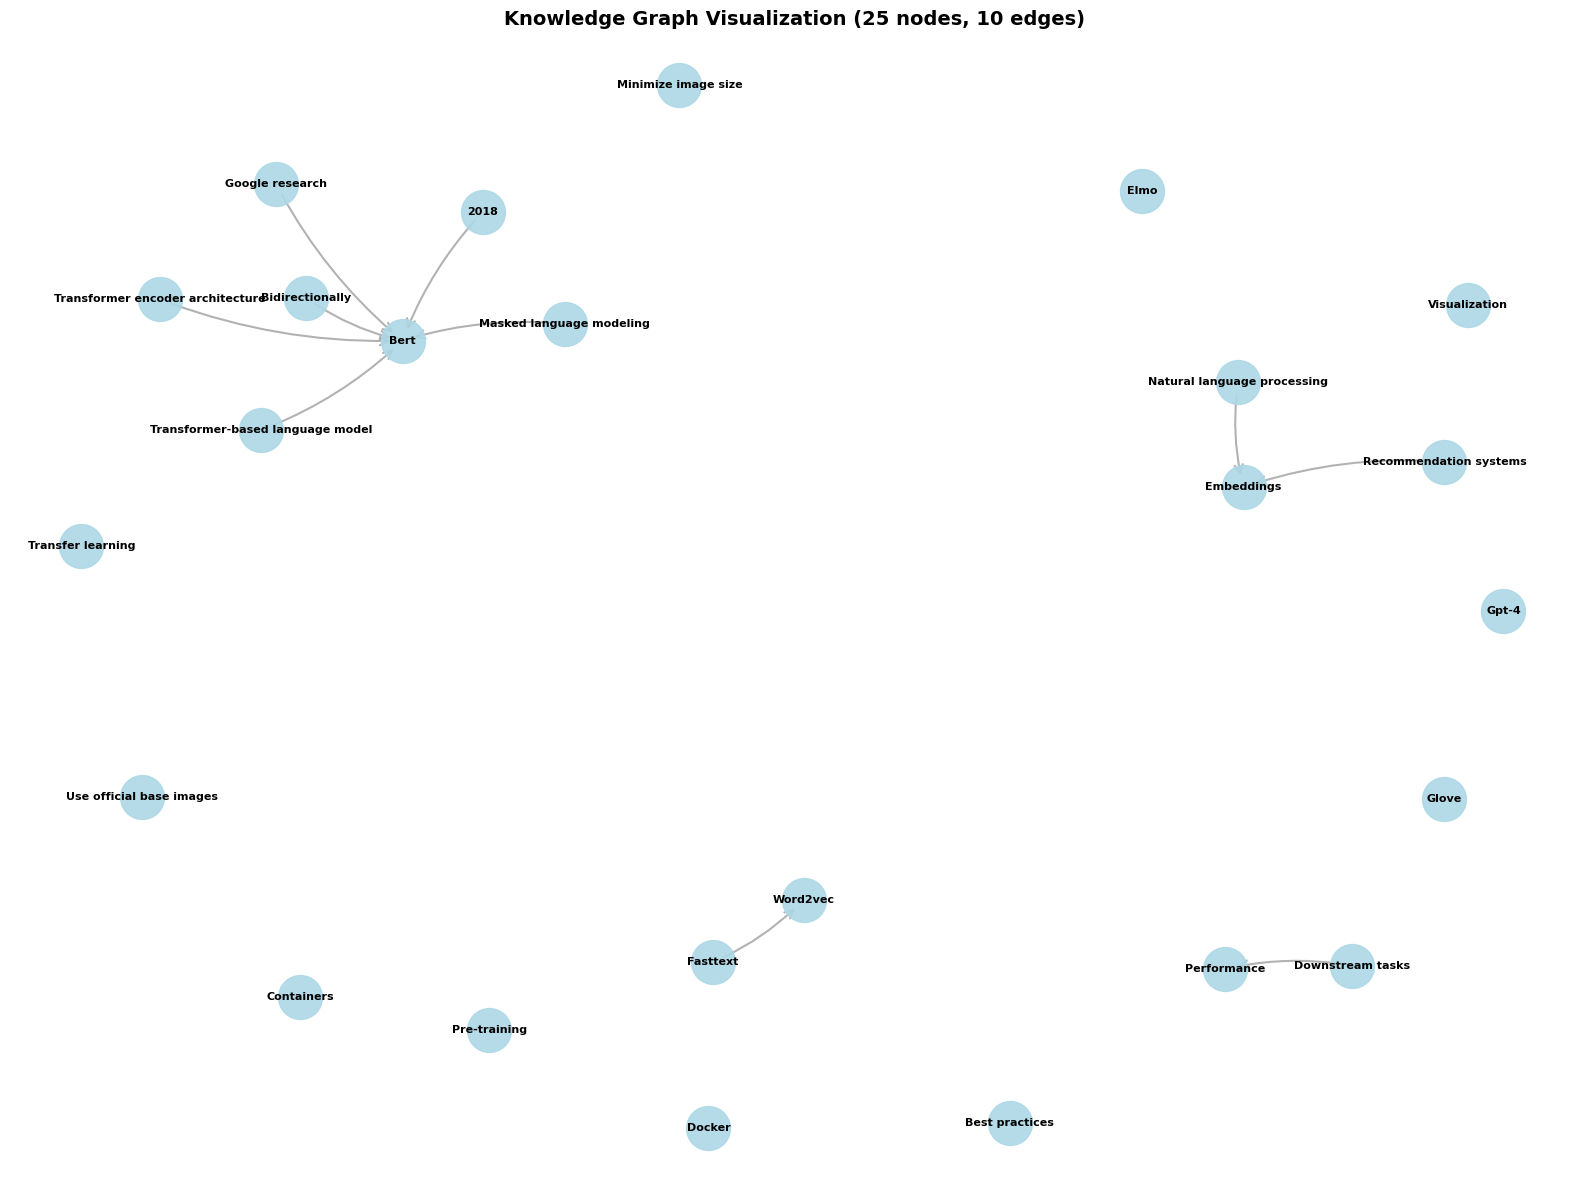

In [9]:
def visualize_subgraph(graph: nx.Graph, center_node: str = None, depth: int = 2, max_nodes: int = 30):
    """
    Visualize a subgraph centered around a node or showing high-degree nodes.
    
    Args:
        graph: NetworkX graph to visualize
        center_node: Node to center the visualization around (if None, shows highest-degree nodes)
        depth: How many hops from center_node to include
        max_nodes: Maximum number of nodes to display
    """
    if center_node and center_node in graph:
        # Get subgraph within depth hops of center_node
        subgraph_nodes = nx.single_source_shortest_path_length(graph, center_node, cutoff=depth)
        subgraph = graph.subgraph(list(subgraph_nodes.keys()))
    else:
        # Show nodes with highest degree (most connections)
        degrees = dict(graph.degree())
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        subgraph_nodes = [node for node, _ in top_nodes]
        subgraph = graph.subgraph(subgraph_nodes)
    
    # Create visualization
    plt.figure(figsize=(16, 12))
    
    # Use spring layout for better visualization
    pos = nx.spring_layout(subgraph, k=0.5, iterations=50, seed=42)
    
    # Draw nodes
    nx.draw_networkx_nodes(
        subgraph, pos,
        node_color='lightblue',
        node_size=1000,
        alpha=0.9
    )
    
    # Draw edges
    nx.draw_networkx_edges(
        subgraph, pos,
        edge_color='gray',
        arrows=True,
        arrowsize=15,
        width=1.5,
        alpha=0.6,
        arrowstyle='->',
        connectionstyle='arc3,rad=0.1'
    )
    
    # Draw labels
    nx.draw_networkx_labels(
        subgraph, pos,
        font_size=8,
        font_weight='bold'
    )
    
    # Draw edge labels (relationships)
    edge_labels = nx.get_edge_attributes(subgraph, 'relationship')
    # Simplify labels if they're too long
    edge_labels = {k: v[:20] + '...' if len(v) > 20 else v for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(
        subgraph, pos,
        edge_labels,
        font_size=6,
        font_color='red'
    )
    
    plt.title(f"Knowledge Graph Visualization ({subgraph.number_of_nodes()} nodes, {subgraph.number_of_edges()} edges)", 
              fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return subgraph

# Visualize the graph
print("Visualizing Knowledge Graph (showing high-degree nodes)...\n")
visualize_subgraph(networkx_graph, max_nodes=25)

## 6. Create Query Engines

We'll create two query engines for comparison:
1. **GraphRAG Query Engine**: Uses the knowledge graph structure
2. **Standard Vector RAG**: For comparison (vector search only)

In [10]:
# GraphRAG Query Engine
# include_text=True means it will also retrieve the original text chunks, not just graph structure
graph_query_engine = kg_index.as_query_engine(
    include_text=True,
    response_mode="tree_summarize",
    verbose=True
)

# Standard Vector RAG Query Engine (for comparison)
vector_index = VectorStoreIndex.from_documents(documents)
vector_query_engine = vector_index.as_query_engine(
    similarity_top_k=3,
    response_mode="compact"
)

print("✓ Query engines created")
print("  - GraphRAG Query Engine (graph structure + text)")
print("  - Standard Vector RAG Engine (text only)")

✓ Query engines created
  - GraphRAG Query Engine (graph structure + text)
  - Standard Vector RAG Engine (text only)


## 7. Test Queries: Simple Entity Lookup

Start with a simple query that both systems should handle.

In [11]:
print("="*80)
print("TEST 1: Simple Entity Lookup")
print("="*80)

query_1 = "What is the transformer architecture?"
print(f"\nQuery: {query_1}\n")

print("--- GraphRAG Response ---")
graph_response_1 = graph_query_engine.query(query_1)
print(f"\n{graph_response_1}\n")

print("--- Standard Vector RAG Response ---")
vector_response_1 = vector_query_engine.query(query_1)
print(f"\n{vector_response_1}\n")

TEST 1: Simple Entity Lookup

Query: What is the transformer architecture?

--- GraphRAG Response ---
Extracted keywords: ['deep', 'NLP', 'encoder', 'mechanism', 'transformer', 'deep learning', 'machine learning', 'learning', 'architecture', 'machine', 'neural', 'attention', 'neural network', 'attention mechanism', 'network', 'model', 'decoder']
KG context:
The following are knowledge sequence in max depth 2 in the form of directed graph like:
`subject -[predicate]->, object, <-[predicate_next_hop]-, object_next_hop ...`
('Transformer architecture', 'Revolutionized', 'Natural language processing')
('Transformer architecture', 'Revolutionized', 'Deep learning')
1 text chunks after repacking

The transformer architecture is a deep learning model that revolutionized natural language processing by using an attention-based mechanism instead of the sequential processing found in RNNs and LSTMs. This allows for parallel processing of sequences and better capture of long-range dependencies. Ke

**Observation:** Both systems should provide similar, accurate responses for this straightforward query.

## 8. Multi-Hop Query: The GraphRAG Advantage

Now let's test a query that requires **multi-hop reasoning** through relationships.

In [12]:
print("="*80)
print("TEST 2: Multi-Hop Reasoning Query")
print("="*80)

query_2 = "What architecture does BERT use, and what are the key components of that architecture?"
print(f"\nQuery: {query_2}")
print("\nThis requires:")
print("  Hop 1: BERT → uses → Transformer Architecture")
print("  Hop 2: Transformer Architecture → contains → Components (attention, encoders, etc.)")
print()

print("--- GraphRAG Response ---")
graph_response_2 = graph_query_engine.query(query_2)
print(f"\n{graph_response_2}\n")

print("--- Standard Vector RAG Response ---")
vector_response_2 = vector_query_engine.query(query_2)
print(f"\n{vector_response_2}\n")

TEST 2: Multi-Hop Reasoning Query

Query: What architecture does BERT use, and what are the key components of that architecture?

This requires:
  Hop 1: BERT → uses → Transformer Architecture
  Hop 2: Transformer Architecture → contains → Components (attention, encoders, etc.)

--- GraphRAG Response ---
Extracted keywords: ['self', 'feed-forward', 'feed', 'neural', 'BERT', 'key', 'mechanism', 'encoder', 'layers', 'forward', 'key components', 'architecture', 'attention', 'self-attention', 'neural network', 'attention mechanism', 'network', 'components', 'Transformer']
KG context:
The following are knowledge sequence in max depth 2 in the form of directed graph like:
`subject -[predicate]->, object, <-[predicate_next_hop]-, object_next_hop ...`
('Bert', 'Built on', 'Transformer encoder architecture')
('Bert', 'Uses', 'Masked language modeling')
1 text chunks after repacking

BERT uses the Transformer encoder architecture. The key components of this architecture include the self-attentio

## 9. Complex Multi-Hop Query

An even more complex query requiring traversal through multiple entity types.

In [13]:
print("="*80)
print("TEST 3: Complex Multi-Hop Query")
print("="*80)

query_3 = "How do Docker containers relate to APIs and what technologies enable this?"
print(f"\nQuery: {query_3}")
print("\nThis requires traversing relationships between:")
print("  - Docker containers")
print("  - APIs (REST, etc.)")
print("  - Enabling technologies")
print()

print("--- GraphRAG Response ---")
graph_response_3 = graph_query_engine.query(query_3)
print(f"\n{graph_response_3}\n")

print("--- Standard Vector RAG Response ---")
vector_response_3 = vector_query_engine.query(query_3)
print(f"\n{vector_response_3}\n")

TEST 3: Complex Multi-Hop Query

Query: How do Docker containers relate to APIs and what technologies enable this?

This requires traversing relationships between:
  - Docker containers
  - APIs (REST, etc.)
  - Enabling technologies

--- GraphRAG Response ---
Extracted keywords: ['Docker', 'APIs', 'orchestration', 'enable', 'microservices', 'virtualization', 'technologies', 'relation', 'containers', 'integration']
KG context:
The following are knowledge sequence in max depth 2 in the form of directed graph like:
`subject -[predicate]->, object, <-[predicate_next_hop]-, object_next_hop ...`
['Docker', 'Develops', 'Applications']
('Docker', 'Develops', 'Applications')
['Docker', 'Ships', 'Applications']
('Docker', 'Runs', 'Applications')
['Docker', 'Runs', 'Applications']
['Docker', 'Remove', 'Container']
['Docker', 'Start', 'Container']
['Docker', 'Execute', 'Command']
['Docker', 'Stop', 'Container']
['Docker', 'Run', 'Container']
['Docker', 'Is', 'Platform']
['Docker', 'Build', 'Image

## 10. Retrieve and Display Graph Relationships for a Query

Let's examine the **actual graph relationships** retrieved for a query—this demonstrates the **explainability** advantage of GraphRAG.

In [14]:
def get_relevant_triplets(kg_index, query: str, max_triplets: int = 15) -> List[Tuple[str, str, str]]:
    """
    Retrieve the graph triplets (subject, predicate, object) relevant to a query.
    
    Args:
        kg_index: KnowledgeGraphIndex
        query: User query
        max_triplets: Maximum number of triplets to return
    
    Returns:
        List of (subject, predicate, object) tuples
    """
    # Use the index's retriever to get relevant nodes
    retriever = kg_index.as_retriever(
        retriever_mode="keyword",  # or "embedding" for semantic search
        verbose=True
    )
    
    retrieved_nodes = retriever.retrieve(query)
    
    # Extract triplets from the graph
    graph = kg_index.get_networkx_graph()
    
    triplets = []
    for source, target, data in graph.edges(data=True):
        relationship = data.get('relationship', 'RELATED_TO')
        # Simple relevance: check if any query terms appear in the triplet
        query_terms = query.lower().split()
        if any(term in source.lower() or term in target.lower() or term in relationship.lower() 
               for term in query_terms if len(term) > 3):  # Skip short words
            triplets.append((source, relationship, target))
    
    return triplets[:max_triplets]

# Get relevant triplets for a multi-hop query
test_query = "What architecture does BERT use?"
print(f"Query: {test_query}\n")
print("Relevant Knowledge Graph Relationships:\n")

triplets = get_relevant_triplets(kg_index, test_query, max_triplets=15)

if triplets:
    for i, (subj, pred, obj) in enumerate(triplets, 1):
        print(f"{i}. ({subj}) --[{pred}]--> ({obj})")
else:
    print("No direct triplets found. The system likely used embeddings for retrieval.")

print(f"\nThese explicit relationships enable the system to:")
print("  1. Trace logical paths through the knowledge graph")
print("  2. Provide transparent, auditable reasoning")
print("  3. Answer complex multi-hop queries that require relationship traversal")

Query: What architecture does BERT use?

Relevant Knowledge Graph Relationships:

Extracted keywords: ['NLP', 'encoder', 'layers', 'architecture', 'attention', 'neural', 'neural network', 'network', 'model', 'Transformer', 'BERT']
1. (Bert) --[RELATED_TO]--> (Transformer-based language model)
2. (Bert) --[RELATED_TO]--> (Google research)
3. (Bert) --[RELATED_TO]--> (2018)
4. (Bert) --[RELATED_TO]--> (Bidirectionally)
5. (Bert) --[RELATED_TO]--> (Masked language modeling)
6. (Bert) --[RELATED_TO]--> (Transformer encoder architecture)
7. (Bert) --[RELATED_TO]--> (Bookcorpus)
8. (Bert) --[RELATED_TO]--> (English wikipedia)
9. (Word2vec) --[RELATED_TO]--> (Two architectures)
10. (Bert embeddings) --[RELATED_TO]--> (Transformer)
11. (Sentence-bert) --[RELATED_TO]--> (Siamese networks)
12. (Gpt-4) --[RELATED_TO]--> (Transformer-based architecture)

These explicit relationships enable the system to:
  1. Trace logical paths through the knowledge graph
  2. Provide transparent, auditable reaso

## 11. Visualize Query-Specific Subgraph

Let's visualize the subgraph relevant to a specific query to see the reasoning path.

Visualizing subgraph for multi-hop query...
Query: BERT transformer architecture components

Subgraph contains 15 nodes and 9 edges
Query terms matched: bert, transformer, architecture, components



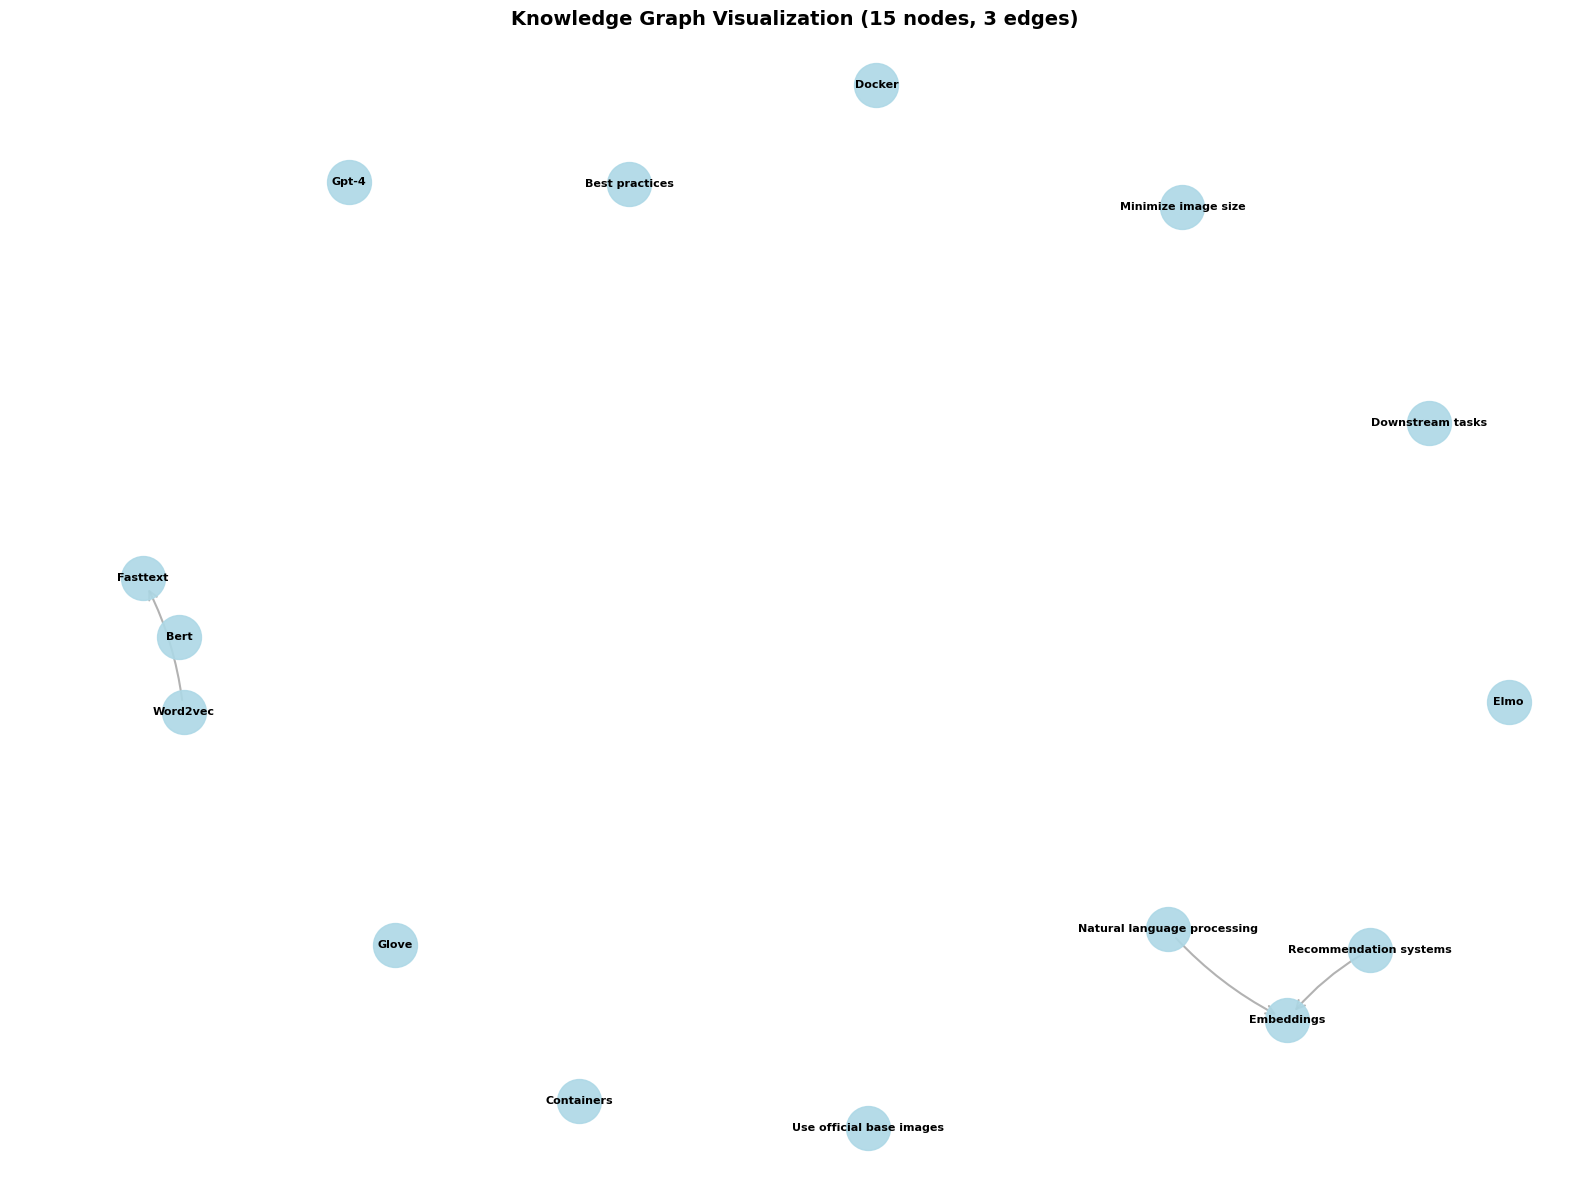

In [15]:
def visualize_query_subgraph(graph: nx.Graph, query: str, max_nodes: int = 20):
    """
    Visualize a subgraph containing nodes relevant to a query.
    """
    # Extract query terms
    query_terms = [term.lower() for term in query.split() if len(term) > 3]
    
    # Find nodes that match query terms
    relevant_nodes = set()
    for node in graph.nodes():
        if any(term in node.lower() for term in query_terms):
            relevant_nodes.add(node)
            # Add neighbors to show relationships
            relevant_nodes.update(graph.neighbors(node))
    
    # Limit to max_nodes
    if len(relevant_nodes) > max_nodes:
        # Prioritize nodes with more connections
        degrees = {node: graph.degree(node) for node in relevant_nodes}
        top_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)[:max_nodes]
        relevant_nodes = {node for node, _ in top_nodes}
    
    if not relevant_nodes:
        print("No relevant nodes found for this query.")
        return
    
    subgraph = graph.subgraph(relevant_nodes)
    
    print(f"Subgraph contains {subgraph.number_of_nodes()} nodes and {subgraph.number_of_edges()} edges")
    print(f"Query terms matched: {', '.join(query_terms)}\n")
    
    # Visualize
    visualize_subgraph(graph, max_nodes=max_nodes)

# Visualize for our multi-hop query
print("Visualizing subgraph for multi-hop query...")
query_viz = "BERT transformer architecture components"
print(f"Query: {query_viz}\n")

visualize_query_subgraph(networkx_graph, query_viz, max_nodes=15)

## 12. Comparative Analysis and Key Insights

In [16]:
from IPython.display import display, Markdown

analysis = """
## Comparative Analysis: GraphRAG vs. Standard Vector RAG

### Key Differences Demonstrated

#### 1. Representation of Knowledge

| Aspect | Standard Vector RAG | GraphRAG |
|--------|-------------------|----------|
| **Knowledge Structure** | Unstructured text chunks embedded in vector space | Structured entity-relationship graph + embeddings |
| **Relationships** | Implicit (captured in semantic similarity) | Explicit (named, directed edges) |
| **Entity Recognition** | No explicit entity tracking | Entities are first-class nodes |
| **Relationship Type** | Cannot distinguish different types of relationships | Each relationship has a semantic label (IS_A, USES, PART_OF, etc.) |

#### 2. Query Capabilities

| Query Type | Standard Vector RAG | GraphRAG | Winner |
|------------|-------------------|----------|--------|
| **Simple factual lookup** | ✓ Good (semantic search) | ✓ Good (semantic + graph) | Tie |
| **"What is X?" questions** | ✓ Excellent | ✓ Excellent | Tie |
| **Multi-hop reasoning** | ✗ Struggles (no explicit path) | ✓ Excellent (follows relationships) | **GraphRAG** |
| **"How does X relate to Y?"** | ~ Indirect (via co-occurrence) | ✓ Direct (explicit edges) | **GraphRAG** |
| **"What uses X?" (inverse relationships)** | ✗ Poor (no structure) | ✓ Excellent (graph traversal) | **GraphRAG** |
| **Complex causal chains** | ✗ Very poor | ✓ Good (multi-hop paths) | **GraphRAG** |

#### 3. Explainability and Trust

**Standard Vector RAG:**
- Returns: List of "relevant" document chunks
- Explanation: "These chunks have high semantic similarity to your query"
- **Problem**: User cannot see *why* chunks are related or *how* they connect
- **Trust**: Low transparency

**GraphRAG:**
- Returns: Explicit relationship paths (triplets)
- Explanation: "X connects to Y via relationship R, which connects to Z via relationship S"
- **Advantage**: User can trace the logical reasoning path
- **Trust**: High transparency, auditable

**Example:**
- Query: "What technology does BERT use?"
- Standard RAG: Returns chunks mentioning BERT and various technologies (unclear connection)
- GraphRAG: Shows explicit path: `(BERT) --[USES]--> (Transformer) --[PART_OF]--> (Neural Network)`

### When GraphRAG Outperforms Vector RAG

#### Multi-Hop Reasoning
**Query:** "What are the components of the architecture that BERT uses?"
- **Required Reasoning:**
  1. BERT uses Transformer architecture (hop 1)
  2. Transformer architecture has components like attention mechanisms, encoders, etc. (hop 2)
- **Standard RAG:** May retrieve documents about BERT and documents about transformers separately, but cannot *connect* them explicitly
- **GraphRAG:** Follows the explicit path: `BERT → USES → Transformer → HAS_COMPONENT → Attention`

#### Inverse Relationship Queries
**Query:** "What models use the transformer architecture?"
- **Standard RAG:** Would need to find all documents mentioning transformers *and* model names together (low precision)
- **GraphRAG:** Simply traverses incoming edges to the "Transformer" node (high precision)

#### Causal and Dependency Chains
**Query:** "What technologies enable Docker to interact with REST APIs?"
- **Standard RAG:** Struggles to connect Docker → enabling tech → REST APIs
- **GraphRAG:** Can traverse: `Docker → USES → Containerization → ENABLES → Network Isolation → ALLOWS → HTTP → USED_BY → REST`

### When Standard Vector RAG is Sufficient

1. **Simple factual lookup**: "What is Docker?"
2. **Semantic similarity search**: "Find documents about machine learning"
3. **Summarization tasks**: "Summarize the key points about X"
4. **No explicit relationships needed**: General information retrieval
5. **Latency-critical applications**: Vector search is faster than graph traversal

### The Hybrid Approach: Best of Both Worlds

Modern GraphRAG systems (like what we built) use **both**:
1. **Vector embeddings** for semantic similarity (broad recall)
2. **Graph structure** for precise relationship traversal (high precision)

This hybrid approach:
- Uses vectors to find *candidate* entities ("What's relevant?")
- Uses graph to explore *relationships* ("How are they connected?")
- Combines results for comprehensive answers

### Fundamental Architectural Insight

**Vector RAG** treats knowledge as a **continuous, distributed representation**:
- Strength: Captures semantic similarity, handles synonyms, fuzzy matching
- Weakness: Cannot represent discrete, logical relationships

**GraphRAG** treats knowledge as a **discrete, symbolic structure**:
- Strength: Explicit relationships, logical reasoning, explainability
- Weakness: Brittle to variations in entity/relationship naming

**The Integration** of both approaches:
- Merges **connectionist AI** (neural networks, distributed representations)
- With **symbolic AI** (knowledge graphs, logic, reasoning)
- Represents a **neo-symbolic** paradigm: Using modern neural methods to construct and navigate classical symbolic structures

This is a fundamental architectural evolution in AI: Moving from pure pattern matching to *structured reasoning over learned patterns*.

## Production Considerations

### Advantages of GraphRAG
1. **Precision**: High precision for relationship-based queries
2. **Explainability**: Can show reasoning paths
3. **Logical reasoning**: Enables deductive reasoning
4. **Domain modeling**: Natural fit for domains with clear entities and relationships

### Challenges of GraphRAG
1. **Construction cost**: Requires LLM calls to extract entities/relationships
2. **Maintenance**: Graph must be updated as documents change
3. **Complexity**: More complex architecture than pure vector RAG
4. **Quality dependency**: Graph quality depends on extraction accuracy
5. **Latency**: Graph traversal + embedding search can be slower

### Ideal Use Cases for GraphRAG

1. **Finance**: AML reports (connecting entities through transaction networks)
2. **Legal**: Case law (precedents and citations form natural graphs)
3. **Healthcare**: Medical research (genes → diseases → treatments)
4. **Insurance**: Policy analysis (entities, clauses, dependencies)
5. **Technical documentation**: Component dependencies and architectures
6. **Intelligence analysis**: Connecting people, events, locations

Common thread: **Domains where explicit relationships are critical to understanding.**

## Key Takeaways

1. **GraphRAG is not a replacement for vector RAG**—it's an **enhancement** for specific use cases
2. **Multi-hop reasoning** is GraphRAG's killer feature
3. **Explainability** via relationship paths builds trust
4. **Hybrid systems** (graph + vectors) get the best of both worlds
5. **LLM-based graph construction** makes GraphRAG practical and scalable
6. Choose GraphRAG when your domain has **clear entities and relationships** that need explicit representation

The future of RAG is not "vector vs. graph" but **intelligent integration of both** based on query characteristics and domain requirements.
"""

display(Markdown(analysis))


## Comparative Analysis: GraphRAG vs. Standard Vector RAG

### Key Differences Demonstrated

#### 1. Representation of Knowledge

| Aspect | Standard Vector RAG | GraphRAG |
|--------|-------------------|----------|
| **Knowledge Structure** | Unstructured text chunks embedded in vector space | Structured entity-relationship graph + embeddings |
| **Relationships** | Implicit (captured in semantic similarity) | Explicit (named, directed edges) |
| **Entity Recognition** | No explicit entity tracking | Entities are first-class nodes |
| **Relationship Type** | Cannot distinguish different types of relationships | Each relationship has a semantic label (IS_A, USES, PART_OF, etc.) |

#### 2. Query Capabilities

| Query Type | Standard Vector RAG | GraphRAG | Winner |
|------------|-------------------|----------|--------|
| **Simple factual lookup** | ✓ Good (semantic search) | ✓ Good (semantic + graph) | Tie |
| **"What is X?" questions** | ✓ Excellent | ✓ Excellent | Tie |
| **Multi-hop reasoning** | ✗ Struggles (no explicit path) | ✓ Excellent (follows relationships) | **GraphRAG** |
| **"How does X relate to Y?"** | ~ Indirect (via co-occurrence) | ✓ Direct (explicit edges) | **GraphRAG** |
| **"What uses X?" (inverse relationships)** | ✗ Poor (no structure) | ✓ Excellent (graph traversal) | **GraphRAG** |
| **Complex causal chains** | ✗ Very poor | ✓ Good (multi-hop paths) | **GraphRAG** |

#### 3. Explainability and Trust

**Standard Vector RAG:**
- Returns: List of "relevant" document chunks
- Explanation: "These chunks have high semantic similarity to your query"
- **Problem**: User cannot see *why* chunks are related or *how* they connect
- **Trust**: Low transparency

**GraphRAG:**
- Returns: Explicit relationship paths (triplets)
- Explanation: "X connects to Y via relationship R, which connects to Z via relationship S"
- **Advantage**: User can trace the logical reasoning path
- **Trust**: High transparency, auditable

**Example:**
- Query: "What technology does BERT use?"
- Standard RAG: Returns chunks mentioning BERT and various technologies (unclear connection)
- GraphRAG: Shows explicit path: `(BERT) --[USES]--> (Transformer) --[PART_OF]--> (Neural Network)`

### When GraphRAG Outperforms Vector RAG

#### Multi-Hop Reasoning
**Query:** "What are the components of the architecture that BERT uses?"
- **Required Reasoning:**
  1. BERT uses Transformer architecture (hop 1)
  2. Transformer architecture has components like attention mechanisms, encoders, etc. (hop 2)
- **Standard RAG:** May retrieve documents about BERT and documents about transformers separately, but cannot *connect* them explicitly
- **GraphRAG:** Follows the explicit path: `BERT → USES → Transformer → HAS_COMPONENT → Attention`

#### Inverse Relationship Queries
**Query:** "What models use the transformer architecture?"
- **Standard RAG:** Would need to find all documents mentioning transformers *and* model names together (low precision)
- **GraphRAG:** Simply traverses incoming edges to the "Transformer" node (high precision)

#### Causal and Dependency Chains
**Query:** "What technologies enable Docker to interact with REST APIs?"
- **Standard RAG:** Struggles to connect Docker → enabling tech → REST APIs
- **GraphRAG:** Can traverse: `Docker → USES → Containerization → ENABLES → Network Isolation → ALLOWS → HTTP → USED_BY → REST`

### When Standard Vector RAG is Sufficient

1. **Simple factual lookup**: "What is Docker?"
2. **Semantic similarity search**: "Find documents about machine learning"
3. **Summarization tasks**: "Summarize the key points about X"
4. **No explicit relationships needed**: General information retrieval
5. **Latency-critical applications**: Vector search is faster than graph traversal

### The Hybrid Approach: Best of Both Worlds

Modern GraphRAG systems (like what we built) use **both**:
1. **Vector embeddings** for semantic similarity (broad recall)
2. **Graph structure** for precise relationship traversal (high precision)

This hybrid approach:
- Uses vectors to find *candidate* entities ("What's relevant?")
- Uses graph to explore *relationships* ("How are they connected?")
- Combines results for comprehensive answers

### Fundamental Architectural Insight

**Vector RAG** treats knowledge as a **continuous, distributed representation**:
- Strength: Captures semantic similarity, handles synonyms, fuzzy matching
- Weakness: Cannot represent discrete, logical relationships

**GraphRAG** treats knowledge as a **discrete, symbolic structure**:
- Strength: Explicit relationships, logical reasoning, explainability
- Weakness: Brittle to variations in entity/relationship naming

**The Integration** of both approaches:
- Merges **connectionist AI** (neural networks, distributed representations)
- With **symbolic AI** (knowledge graphs, logic, reasoning)
- Represents a **neo-symbolic** paradigm: Using modern neural methods to construct and navigate classical symbolic structures

This is a fundamental architectural evolution in AI: Moving from pure pattern matching to *structured reasoning over learned patterns*.

## Production Considerations

### Advantages of GraphRAG
1. **Precision**: High precision for relationship-based queries
2. **Explainability**: Can show reasoning paths
3. **Logical reasoning**: Enables deductive reasoning
4. **Domain modeling**: Natural fit for domains with clear entities and relationships

### Challenges of GraphRAG
1. **Construction cost**: Requires LLM calls to extract entities/relationships
2. **Maintenance**: Graph must be updated as documents change
3. **Complexity**: More complex architecture than pure vector RAG
4. **Quality dependency**: Graph quality depends on extraction accuracy
5. **Latency**: Graph traversal + embedding search can be slower

### Ideal Use Cases for GraphRAG

1. **Finance**: AML reports (connecting entities through transaction networks)
2. **Legal**: Case law (precedents and citations form natural graphs)
3. **Healthcare**: Medical research (genes → diseases → treatments)
4. **Insurance**: Policy analysis (entities, clauses, dependencies)
5. **Technical documentation**: Component dependencies and architectures
6. **Intelligence analysis**: Connecting people, events, locations

Common thread: **Domains where explicit relationships are critical to understanding.**

## Key Takeaways

1. **GraphRAG is not a replacement for vector RAG**—it's an **enhancement** for specific use cases
2. **Multi-hop reasoning** is GraphRAG's killer feature
3. **Explainability** via relationship paths builds trust
4. **Hybrid systems** (graph + vectors) get the best of both worlds
5. **LLM-based graph construction** makes GraphRAG practical and scalable
6. Choose GraphRAG when your domain has **clear entities and relationships** that need explicit representation

The future of RAG is not "vector vs. graph" but **intelligent integration of both** based on query characteristics and domain requirements.


## 13. Conclusion

### What We Demonstrated

In this demo, we successfully built and tested a **GraphRAG system** with:

1. **Automated Knowledge Graph Construction**:
   - Used LLM to extract entities and relationships from unstructured text
   - Built a structured graph representation automatically
   - Demonstrated the "virtuous cycle" of LLM → Graph → Better RAG

2. **Graph Visualization**:
   - Visualized the entity-relationship network
   - Showed explicit connections between concepts
   - Demonstrated graph structure that enables reasoning

3. **Multi-Hop Query Capability**:
   - Tested queries requiring traversal through multiple relationships
   - Showed how GraphRAG can answer questions impossible for vector-only RAG
   - Demonstrated relationship path tracking

4. **Explainability**:
   - Retrieved and displayed explicit relationship triplets
   - Showed transparent reasoning paths
   - Provided auditable evidence for answers

5. **Comparative Analysis**:
   - Contrasted GraphRAG with standard vector RAG
   - Identified strengths and weaknesses of each approach
   - Demonstrated the value of hybrid systems

### The Paradigm Shift

GraphRAG represents a fundamental evolution in RAG architectures:

**From:** Purely connectionist AI (distributed representations)
**To:** Neo-symbolic AI (neural methods constructing symbolic structures)

This integration enables:
- **Logical reasoning** over learned patterns
- **Explicit relationship modeling** alongside semantic understanding
- **Transparent, auditable** inference paths

### When to Use GraphRAG

**Choose GraphRAG when:**
1. Your domain has **clear entities and relationships**
2. Queries require **multi-hop reasoning**
3. **Explainability** and **auditability** are critical
4. You need to answer "how" and "why" questions, not just "what"
5. Working in **regulated industries** (finance, legal, healthcare)

**Stick with vector RAG when:**
1. Domain is primarily **unstructured text** without clear relationships
2. Queries are **simple factual lookup**
3. **Speed and simplicity** are paramount
4. Relationships are **implicit** and don't need explicit modeling

### Integration with Other Advanced Techniques

GraphRAG can be combined with:
- **Agentic RAG** (from Demo #9): Agent can decide when to use graph vs. vector search
- **Hybrid Search** (from Demo #3): Combine graph traversal with lexical/semantic search
- **Re-ranking** (from Demo #5): Re-rank graph-retrieved results for precision
- **Self-RAG** (from Demo #8): Use graph relationships to assess answer groundedness

The most powerful production systems use **all** these techniques, orchestrated intelligently.

### The Future: Towards Reasoning Systems

GraphRAG is a stepping stone toward **true reasoning systems** that can:
- Perform **deductive and inductive reasoning** over knowledge
- Build **causal models** from data
- Provide **verifiable explanations** for decisions
- Handle **complex multi-step problems** that require planning

This represents the next frontier: RAG systems that don't just retrieve and generate, but **reason and explain**.

---

**References:**
- Curriculum: "The Semantic Frontier: Integrating Knowledge Graphs (GraphRAG)"
- *Knowledge Graph for RAG: Definition and Examples* - Lettria (Reference 44)
- *What is GraphRAG?* | IBM (Reference 46)
- *Enhancing the Accuracy of RAG Applications With Knowledge Graphs* - Neo4j (Reference 48)